# Классификация изображений CIFAR-10

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов:

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

## Импорты

In [91]:
from sklearn import metrics
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.constraints as C
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

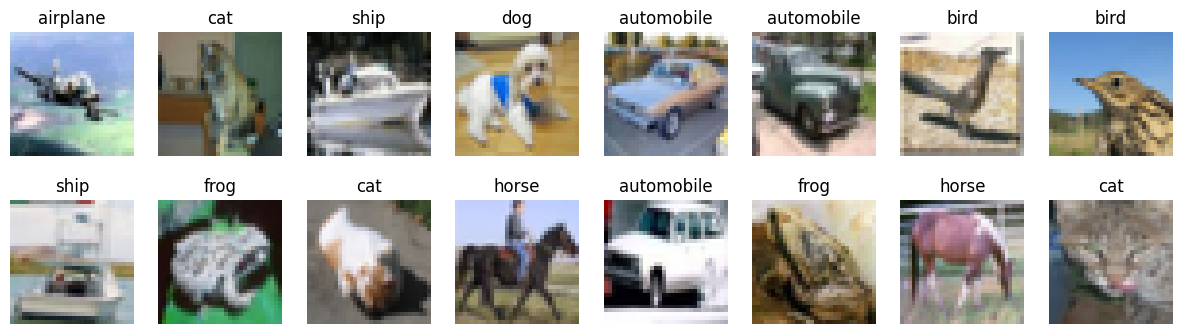

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

## Готовим данные

In [7]:
# нормализуем входы
x_train_norm = x_train.astype('float32') / 255 - 0.5
x_test_norm = x_test.astype('float32') / 255 - 0.5

# encoding
y_train_e = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_e = keras.utils.to_categorical(y_test, NUM_CLASSES)

## Задаем *дефолтную* архитектуру сети

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе;
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [105]:
model = M.Sequential()
model.add(L.Input(shape=(32, 32, 3)))
# Добавляем 4 сверточных слоя
model.add(L.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(L.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Dropout(0.25))

model.add(L.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(L.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(L.MaxPooling2D(pool_size=(2, 2)))
model.add(L.Dropout(0.25))

# Преобразуем в 1D массив
model.add(L.Flatten())

# Полносвязные слои
model.add(L.Dense(256, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(10, activation='softmax'))

In [106]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,234 (4.14 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

### Тренируем модель

In [107]:
BATCH_SIZE = 32
EPOCHS = 20

K.clear_session()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(
    x_train_norm, y_train_e,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test_norm, y_test_e),
    shuffle=False
)

Epoch 1/20
  35/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1404 - loss: 2.2920

W0000 00:00:1716061242.639024     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3603 - loss: 1.7306

W0000 00:00:1716061253.354487     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716061254.276373     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3603 - loss: 1.7304 - val_accuracy: 0.6135 - val_loss: 1.0985
Epoch 2/20
  34/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6041 - loss: 1.1435

W0000 00:00:1716061255.150855     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5965 - loss: 1.1447 - val_accuracy: 0.6850 - val_loss: 0.8938
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6537 - loss: 0.9767 - val_accuracy: 0.7183 - val_loss: 0.7969
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6920 - loss: 0.8746 - val_accuracy: 0.7145 - val_loss: 0.8234
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7151 - loss: 0.8082 - val_accuracy: 0.7476 - val_loss: 0.7284
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7327 - loss: 0.7593 - val_accuracy: 0.7577 - val_loss: 0.6971
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7506 - loss: 0.7160 - val_accuracy: 0.7452 - val_loss: 0.7427
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7583 - loss: 0.6808 - val_accuracy: 0.7489 - val_loss: 0.7400
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7662 - loss: 0.6540 - val_accurac

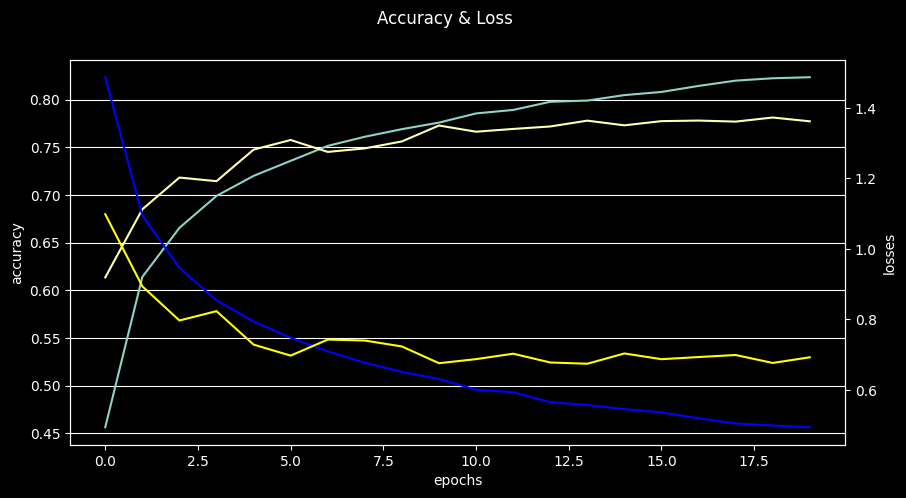

In [108]:
plt.style.use(['dark_background'])
_, ax1 = plt.subplots(sharex=True, figsize=(10, 5))
plt.suptitle('Accuracy & Loss')
ax1.plot(model.history.history['accuracy'])
ax1.plot(model.history.history['val_accuracy'])
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
plt.grid(axis='y')
ax2 = ax1.twinx()
ax2.plot(model.history.history['loss'], color='b')
ax2.plot(model.history.history['val_loss'], color='yellow')
ax2.set_ylabel('losses')
plt.show()

Видно некоторое переобучение.

In [110]:
predicts = np.argmax(model.predict(x_test_norm), axis = 1)
print(metrics.classification_report(y_test, predicts,digits=5, target_names=cifar10_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

    airplane    0.79284   0.81900   0.80571      1000
  automobile    0.86604   0.91800   0.89126      1000
        bird    0.75450   0.58700   0.66029      1000
         cat    0.60307   0.62900   0.61576      1000
        deer    0.76906   0.70600   0.73618      1000
         dog    0.67965   0.69800   0.68870      1000
        frog    0.73649   0.88600   0.80436      1000
       horse    0.84751   0.81700   0.83198      1000
        ship    0.86792   0.87400   0.87095      1000
       truck    0.86763   0.83900   0.85308      1000

    accuracy                        0.77730     10000
   macro avg    0.77847   0.77730   0.77583     10000
weighted avg    0.77847   0.77730   0.77583     10000



## Модифицируем архитектуру

In [96]:
K.clear_session()

model = M.Sequential()
model.add(L.Input(shape=(32, 32, 3)))
model.add(L.Conv2D(
    16, kernel_size=3, activation='relu', padding='same',
    kernel_constraint=C.MaxNorm(3))
)
model.add(L.BatchNormalization())
model.add(L.Dropout(0.3))
model.add(L.Conv2D(
    32, kernel_size=5, activation='relu', padding='same',
    kernel_constraint=C.MaxNorm(3))
)
model.add(L.BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(0.3))

model.add(L.Conv2D(
    64, kernel_size=3, activation='relu', padding='same',
    kernel_constraint=C.MaxNorm(3))
)
model.add(L.BatchNormalization())
model.add(L.Dropout(0.3))
model.add(L.Conv2D(
    128, kernel_size=3, activation='relu', padding='same',
    kernel_constraint=C.MaxNorm(3))
)
model.add(L.BatchNormalization())
model.add(L.MaxPool2D())
model.add(L.Dropout(0.3))

model.add(L.Flatten())
model.add(L.Dense(1024, activation='relu',
    kernel_constraint=C.MaxNorm(3)))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.5))
model.add(L.Dense(10, activation='softmax'))

In [97]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,510,570 (32.47 MB)

 Trainable params: 8,508,042 (32.46 MB)

 Non-trainable params: 2,528 (9.88 KB)

### Тренируем модель

In [98]:
BATCH_SIZE = 64
EPOCHS = 50

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.fit(
    x_train_norm, y_train_e,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test_norm, y_test_e),
    shuffle=False
)

Epoch 1/50
 13/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.1775 - loss: 3.3035

W0000 00:00:1716060285.703378     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3860 - loss: 1.9684

W0000 00:00:1716060305.976205     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716060307.056779     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.3861 - loss: 1.9679 - val_accuracy: 0.5492 - val_loss: 1.3539
Epoch 2/50
 16/782 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5735 - loss: 1.2074

W0000 00:00:1716060307.984826     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5908 - loss: 1.1575 - val_accuracy: 0.6568 - val_loss: 0.9983
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6623 - loss: 0.9550 - val_accuracy: 0.7037 - val_loss: 0.8885
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6987 - loss: 0.8553 - val_accuracy: 0.7244 - val_loss: 0.8580
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7200 - loss: 0.7945 - val_accuracy: 0.7272 - val_loss: 0.8383
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7370 - loss: 0.7572 - val_accuracy: 0.7633 - val_loss: 0.7059
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7540 - loss: 0.7043 - val_accuracy: 0.7533 - val_loss: 0.7433
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7636 - loss: 0.6738 - val_accuracy: 0.7693 - val_loss: 0.7397
Epoch 9/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7760 - loss: 0.6446 - val_accuracy: 0.77

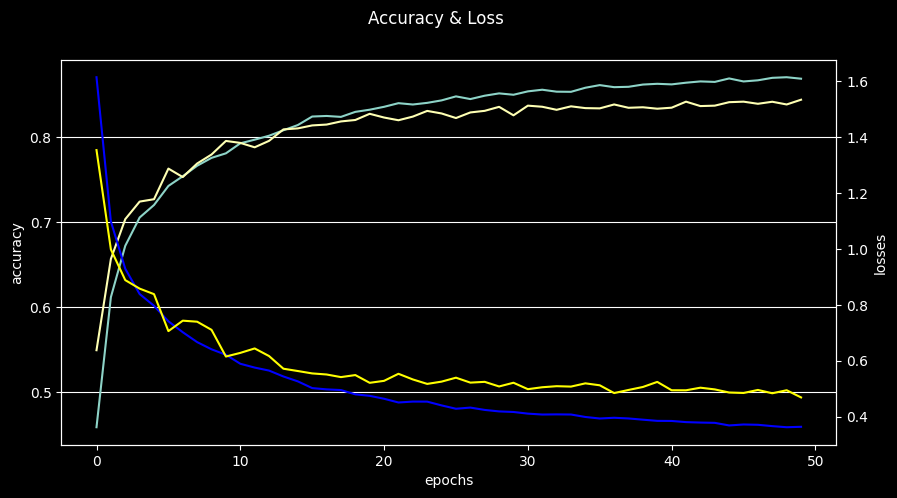

In [99]:
plt.style.use(['dark_background'])
_, ax1 = plt.subplots(sharex=True, figsize=(10, 5))
plt.suptitle('Accuracy & Loss')
ax1.plot(model.history.history['accuracy'])
ax1.plot(model.history.history['val_accuracy'])
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
plt.grid(axis='y')
ax2 = ax1.twinx()
ax2.plot(model.history.history['loss'], color='b')
ax2.plot(model.history.history['val_loss'], color='yellow')
ax2.set_ylabel('losses')
plt.show()

In [101]:
predicts = np.argmax(model.predict(x_test_norm), axis = 1)
print(metrics.classification_report(y_test, predicts,digits=5, target_names=cifar10_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

    airplane    0.84737   0.85500   0.85117      1000
  automobile    0.92084   0.91900   0.91992      1000
        bird    0.83240   0.74000   0.78348      1000
         cat    0.72953   0.70400   0.71654      1000
        deer    0.78962   0.86700   0.82650      1000
         dog    0.78012   0.77700   0.77856      1000
        frog    0.82358   0.91500   0.86689      1000
       horse    0.89162   0.87200   0.88170      1000
        ship    0.90900   0.91900   0.91397      1000
       truck    0.92804   0.87700   0.90180      1000

    accuracy                        0.84450     10000
   macro avg    0.84521   0.84450   0.84405     10000
weighted avg    0.84521   0.84450   0.84405     10000



Этот результат для сетей со сверточными слоями, конечно, не предел, но для примера возможного решения вполне пока сгодится.